In [ ]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import numpy as np
import torch

# Load dataset
file_path = "/content/ensemble_sentiment_labels (1).csv"
df = pd.read_csv(file_path)

# Filter valid rows
df = df[df["ensemble_label"].notna() & df["text_clean"].notna()]

# Encode labels
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["ensemble_label"])

print("Class distribution:\n", df["label"].value_counts())


Class distribution:
 label
1    549
0    285
Name: count, dtype: int64


In [ ]:
from transformers import AutoTokenizer
from datasets import Dataset

# Load DistilBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["text_clean"], padding="max_length", truncation=True, max_length=128)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from datasets import Dataset

train_val_df, unseen_df = train_test_split(
    df,
    test_size=0.1,
    stratify=df["label"],
    random_state=42
)

train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.2,   # 20% of 90% = 18% overall
    stratify=train_val_df["label"],
    random_state=42
)

print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Unseen test size:", len(unseen_df))

train_majority = train_df[train_df.label == 1]
train_minority = train_df[train_df.label == 0]

train_minority_upsampled = resample(
    train_minority,
    replace=True,
    n_samples=len(train_majority),
    random_state=42
)

train_df_balanced = pd.concat([train_majority, train_minority_upsampled])

train_dataset = Dataset.from_pandas(train_df_balanced)
val_dataset   = Dataset.from_pandas(val_df)
unseen_dataset = Dataset.from_pandas(unseen_df)

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset   = val_dataset.map(tokenize, batched=True)
unseen_dataset = unseen_dataset.map(tokenize, batched=True)

cols = ["input_ids", "attention_mask", "label"]
train_dataset.set_format(type="torch", columns=cols)
val_dataset.set_format(type="torch", columns=cols)
unseen_dataset.set_format(type="torch", columns=cols)


Train size: 600
Validation size: 150
Unseen test size: 84


Map:   0%|          | 0/790 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/84 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="macro")
    return {"accuracy": acc, "macro_f1": f1}

print("\n Training DistilBERT")

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(label_encoder.classes_)
)

training_args = TrainingArguments(
    output_dir="./results",
    save_strategy="no",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    learning_rate=3e-5,
    weight_decay=0.05,
    warmup_ratio=0.1,
    logging_dir="./logs",
    logging_strategy="no",
    report_to=[]
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

best_f1 = 0
patience = 1
wait = 0
max_epochs = 3

for epoch in range(max_epochs):
    print(f"\nEpoch {epoch + 1}/{max_epochs}")
    trainer.train()

    metrics = trainer.evaluate(val_dataset)
    current_f1 = metrics["eval_macro_f1"]
    print(f"Validation Macro-F1: {current_f1:.4f}")

    if current_f1 > best_f1:
        best_f1 = current_f1
        wait = 0
        trainer.save_model("./best_model")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break



🚀 Training DistilBERT


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-381831366.py:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Epoch 1/3


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss


Validation Macro-F1: 0.6535

Epoch 2/3


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss


Validation Macro-F1: 0.7429

Epoch 3/3


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss


Step,Training Loss


Validation Macro-F1: 0.7555

📊 Final Evaluation on Unseen Test Set


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.5436903834342957, 'eval_accuracy': 0.7976190476190477, 'eval_macro_f1': 0.7812164853684694, 'eval_runtime': 14.5577, 'eval_samples_per_second': 5.77, 'eval_steps_per_second': 0.412, 'epoch': 1.0}



Evaluation on Validation Data:


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation Metrics: {'eval_loss': 0.5433756709098816, 'eval_accuracy': 0.7933333333333333, 'eval_macro_f1': 0.7555076502444924, 'eval_runtime': 28.7869, 'eval_samples_per_second': 5.211, 'eval_steps_per_second': 0.347, 'epoch': 1.0}


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Classification Report (Validation Data):
              precision    recall  f1-score   support

    negative       0.75      0.59      0.66        51
    positive       0.81      0.90      0.85        99

    accuracy                           0.79       150
   macro avg       0.78      0.74      0.76       150
weighted avg       0.79      0.79      0.79       150



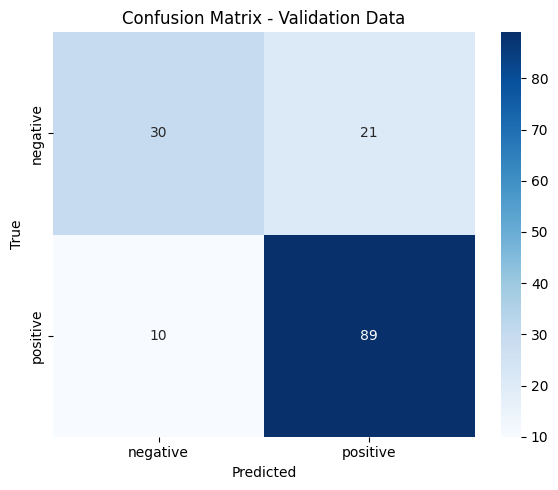


Evaluation on Unseen Test Data:


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Unseen Test Metrics: {'eval_loss': 0.5436903834342957, 'eval_accuracy': 0.7976190476190477, 'eval_macro_f1': 0.7812164853684694, 'eval_runtime': 15.2666, 'eval_samples_per_second': 5.502, 'eval_steps_per_second': 0.393, 'epoch': 1.0}


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Classification Report (Unseen Test Data):
              precision    recall  f1-score   support

    negative       0.69      0.76      0.72        29
    positive       0.87      0.82      0.84        55

    accuracy                           0.80        84
   macro avg       0.78      0.79      0.78        84
weighted avg       0.80      0.80      0.80        84



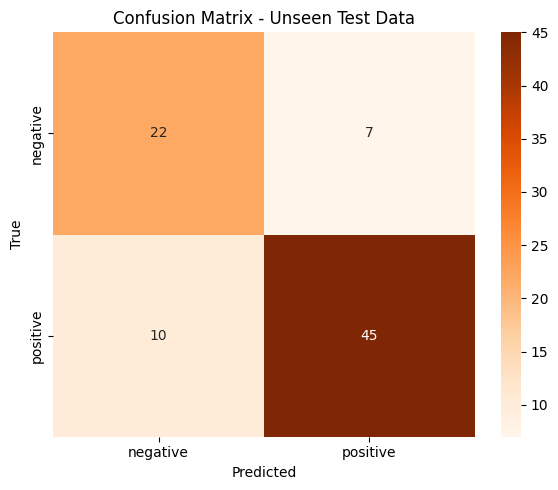

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Validation Evaluation ---
print("\nEvaluation on Validation Data:")
val_metrics = trainer.evaluate(val_dataset)
print("Validation Metrics:", val_metrics)

preds_val = trainer.predict(val_dataset)
y_true_val = preds_val.label_ids
y_pred_val = np.argmax(preds_val.predictions, axis=-1)

print("\nClassification Report (Validation Data):")
print(classification_report(y_true_val, y_pred_val, target_names=label_encoder.classes_))

cm_val = confusion_matrix(y_true_val, y_pred_val)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Validation Data")
plt.tight_layout()
plt.show()

# --- Unseen Test Evaluation ---
print("\nEvaluation on Unseen Test Data:")
unseen_metrics = trainer.evaluate(unseen_dataset)
print("Unseen Test Metrics:", unseen_metrics)

preds_unseen = trainer.predict(unseen_dataset)
y_true_unseen = preds_unseen.label_ids
y_pred_unseen = np.argmax(preds_unseen.predictions, axis=-1)

print("\nClassification Report (Unseen Test Data):")
print(classification_report(y_true_unseen, y_pred_unseen, target_names=label_encoder.classes_))

cm_unseen = confusion_matrix(y_true_unseen, y_pred_unseen)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_unseen, annot=True, fmt="d", cmap="Oranges",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Unseen Test Data")
plt.tight_layout()
plt.show()
